<a href="https://colab.research.google.com/github/hny-iitd/RFM-Analysis-Class-Tutorial-/blob/main/GT%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span>
<b>Author:</b> <a href="https://github.com/jisukimmmm">Jisu Kim</a><br/>
<b>Python version:</b>  >=3.6<br/>
<b>Last update:</b> 09/11/2023
</span>


<a id='top'></a>
# *Exercise using existing Twitter data*

Data is accessible here: https://data.world/alexfilatov/2016-usa-presidential-election-tweets

The data contains sample of 100k records including original tweets and retweet records (with empty tweet text field).

The author has also computed levels of polarity and subjectivity of tweets that contains twitter handles.
Polarity and subjectivity were calculated using Python NTLK open source server (this one https://github.com/sguignot/textblob-api-server).

<b>Polarity</b>: Polarity refers to the degree of positivity or negativity of a text. It is a numerical value that ranges from -1 to 1.

<b>Subjectivity</b>: Subjectivity refers to the degree of personal opinion or factual information contained in a text. It is a numerical value that ranges from 0 to 1, where 0 indicates a text that contains only factual information and 1 indicates a text that contains only personal opinion.


Here we will leverage Twitter data to study topics around migration in the <b>USA presidential election in 2016</b>.
The goal is to find out the keywords and how they are associated with candidates of the election.

## Table of Contents

1. [Installing packages](#install)
2. [Upload data](#upload)
3. [Data pre-processing](#data)
4. [Polarity and Subjectivity of the topic "migration"](#polarity)
4. [Topic modeling](#topic)
5. [Semnatic network visualisation](#visu)

<a id='install'></a>
## 1. Installing packages ([to top](#install))

We begin by installing necessary packages and need to make sure that it is installed and working.

Packages can be downloaded using ``pip``. If already on jupyter notebook, you can use ``!pip``.

    pip install datetime

Once it is installed correctly, it is ready to be used. We then import packages here.

In [16]:
import pandas as pd
import csv
import datetime
import numpy as np
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
import networkx as nx

<a id='Upload'></a>
## 2. Upload data ([to top](#top))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd

def excel_to_csv(excel_file, csv_file):
    try:
        # Read Excel file
        df = pd.read_excel(excel_file)

        # Write to CSV file
        df.to_csv(csv_file, index=False)

        print(f'Successfully converted {excel_file} to {csv_file}')
    except Exception as e:
        print(f'Error: {e}')

# Specify your Excel file and desired CSV file
excel_file_path = '/content/drive/MyDrive/GT Text Analysis/Text Mining Analysis Dataset.xlsx'
csv_file_path = '/content/drive/MyDrive/GT Text Analysis/output_file.csv'

# Call the function
excel_to_csv(excel_file_path, csv_file_path)


Successfully converted /content/drive/MyDrive/GT Text Analysis/Text Mining Analysis Dataset.xlsx to /content/drive/MyDrive/GT Text Analysis/output_file.csv


In [18]:
df=pd.read_csv('/content/drive/MyDrive/GT Text Analysis/output_file.csv')
print(len(df))
df.head()

33


,Text
0,"See, I mean I have a lot of critique for India..."
1,"So first of all Actually, I did a one small pr..."
2,What I feel is these mid-sized organizations h...
3,So ...first Honey can you brief me about what...
4,Yeah so see there are two kind of EdTech start...


<a id='data'></a>
## 3. Data pre-processing  ([to top](#top))

We pre-process our data.

1. We first select the rows that contain the topic of your interest. E.g., here we select only the tweets that contain the following words: "migrants, migration, immigrants, immigration"
2. We remove stop words from each tweet. e.g., "and", "are", "he", "this"...
3. We change the texts to all lower cases
4. We remove hashtags
5. We remove special characters. e.g., dots, commas, asterisk...
6. To avoid having repetition, we replace a word e.g., replace "trump" with "realdonaldtrump" in the text column

In [20]:
# Select only the tweets that contains the topic of migration
mig_Tweets=df[df['Text'].str.contains('consumer|analytics|privacy|legal|data|security',  na=False)]
len(mig_Tweets)

32

In [22]:
nltk.download('stopwords')

# preprocess the text data
stop_words = set(stopwords.words('english'))
mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words and word not in string.punctuation]))
# change the texts to all lower cases
mig_Tweets['Text'] = mig_Tweets['Text'].str.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-22-9e68e36c3ef6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words and word not in string.punctuation]))
<ipython-input-22-9e68e36c3ef6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['Text'] = mig_Tweets['Text'].str.lower()


In [24]:
# remove hashtags
mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: re.sub(r'#\w+', '', x))
# remove special characters from the text column
mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# replace "trump" with "realdonaldtrump" in the text column
mig_Tweets['Text'] = mig_Tweets['Text'].str.replace(r'\b(trump|donald|trumps)\b', 'realdonaldtrump', regex=True)
mig_Tweets['Text'] = mig_Tweets['Text'].str.replace(r'\b(clinton|hillary)\b', 'hillaryclinton', regex=True)

<ipython-input-24-cc5254c10c93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: re.sub(r'#\w+', '', x))
<ipython-input-24-cc5254c10c93>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['Text'] = mig_Tweets['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
<ipython-input-24-cc5254c10c93>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [25]:
# preprocess the text data
texts = mig_Tweets['Text'].tolist()

texts = [[word for word in document.split()] for document in texts]

<a id='polarity'></a>
## 4. Polarity and subjectivity on topic of migration  ([to top](#top))

Let's check also the level of polarity and subjectivity on tweets that contain the word migration

Most of tweets have neutral sentiment on the topic.
But aside from that we see that the topic is very polarised.

So what do people talk about?

<ipython-input-31-c0a5027d8bad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['polarity'] = mig_Tweets['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


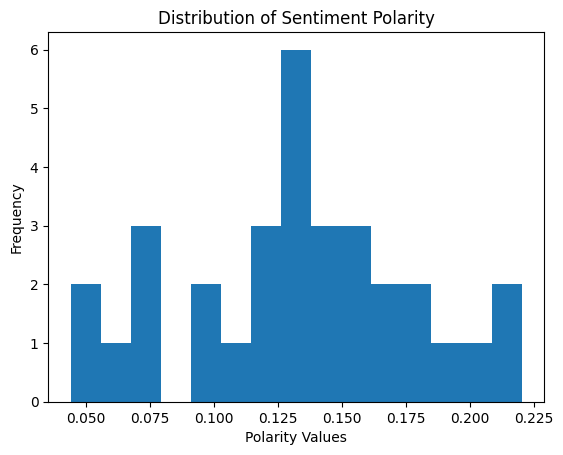

In [31]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Assuming mig_Tweets is your DataFrame with a 'text' column
mig_Tweets['polarity'] = mig_Tweets['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a histogram showing the distribution of polarity values
plt.hist(mig_Tweets['polarity'], bins=15)
plt.xlabel('Polarity Values')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()


Most of the tweets contain only factual information and also a good amount of tweets contain both factual information and perisonal opinion on the topic.

<ipython-input-33-e6428201aa71>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mig_Tweets['subjectivity'] = mig_Tweets['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


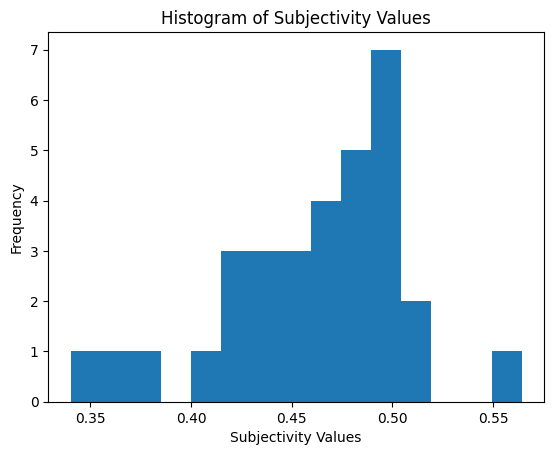

In [33]:
# create a histogram showing the distribution of values
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Assuming mig_Tweets is your DataFrame with a 'text' column
mig_Tweets['subjectivity'] = mig_Tweets['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Create a histogram showing the distribution of subjectivity values
plt.hist(mig_Tweets['subjectivity'], bins=15)
plt.xlabel('Subjectivity Values')
plt.ylabel('Frequency')
plt.title('Histogram of Subjectivity Values')
plt.show()

<a id='topic'></a>
## 5. Topic modeling  ([to top](#top))

We create a dictionary and corpus from the preprocessed text data, and train an <b> LDA model </b> with 10 topics. We print the top 10 words for each topic.

"Latent Dirichlet Allocation (LDA) is a statistical model used in natural language processing to discover abstract topics in a collection of documents. The goal of LDA is to find the topics that a document belongs to based on the words in it. LDA represents documents as a mixture of topics, and each topic is a mixture of words. The model assumes that documents with similar topics will use a similar group of words. LDA consists of two parts: the words within a document and the probability of words belonging to a topic."


In [28]:
# create a dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# train the LDA model (passes=Number of passes through the corpus during training.)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

# print the topics
topics = lda_model.show_topics(num_topics=10, num_words=10)
for topic in topics:
    print(topic)

(0, '0.001*"data" + 0.001*"ai" + 0.001*"like" + 0.001*"business" + 0.001*"say" + 0.001*"also" + 0.001*"know" + 0.001*"so" + 0.001*"technology" + 0.001*"product"')
(1, '0.001*"like" + 0.001*"data" + 0.001*"ai" + 0.001*"technology" + 0.001*"know" + 0.001*"say" + 0.001*"so" + 0.001*"also" + 0.001*"people" + 0.000*"lot"')
(2, '0.001*"data" + 0.001*"know" + 0.001*"like" + 0.001*"would" + 0.001*"technology" + 0.001*"ai" + 0.001*"also" + 0.001*"right" + 0.001*"business" + 0.001*"people"')
(3, '0.001*"data" + 0.000*"like" + 0.000*"technology" + 0.000*"know" + 0.000*"so" + 0.000*"business" + 0.000*"right" + 0.000*"ai" + 0.000*"something" + 0.000*"say"')
(4, '0.031*"like" + 0.025*"data" + 0.010*"also" + 0.007*"right" + 0.007*"ai" + 0.007*"one" + 0.007*"so" + 0.006*"people" + 0.006*"company" + 0.006*"know"')
(5, '0.021*"know" + 0.014*"like" + 0.011*"data" + 0.011*"ai" + 0.009*"would" + 0.008*"think" + 0.007*"analytics" + 0.007*"yeah" + 0.007*"definitely" + 0.007*"people"')
(6, '0.019*"data" + 0.0

<a id='visu'></a>
## 6. Visualisation  ([to top](#top))


We create a semantic network by adding nodes for each word in the text and edges between words that appear together in the same sentence.

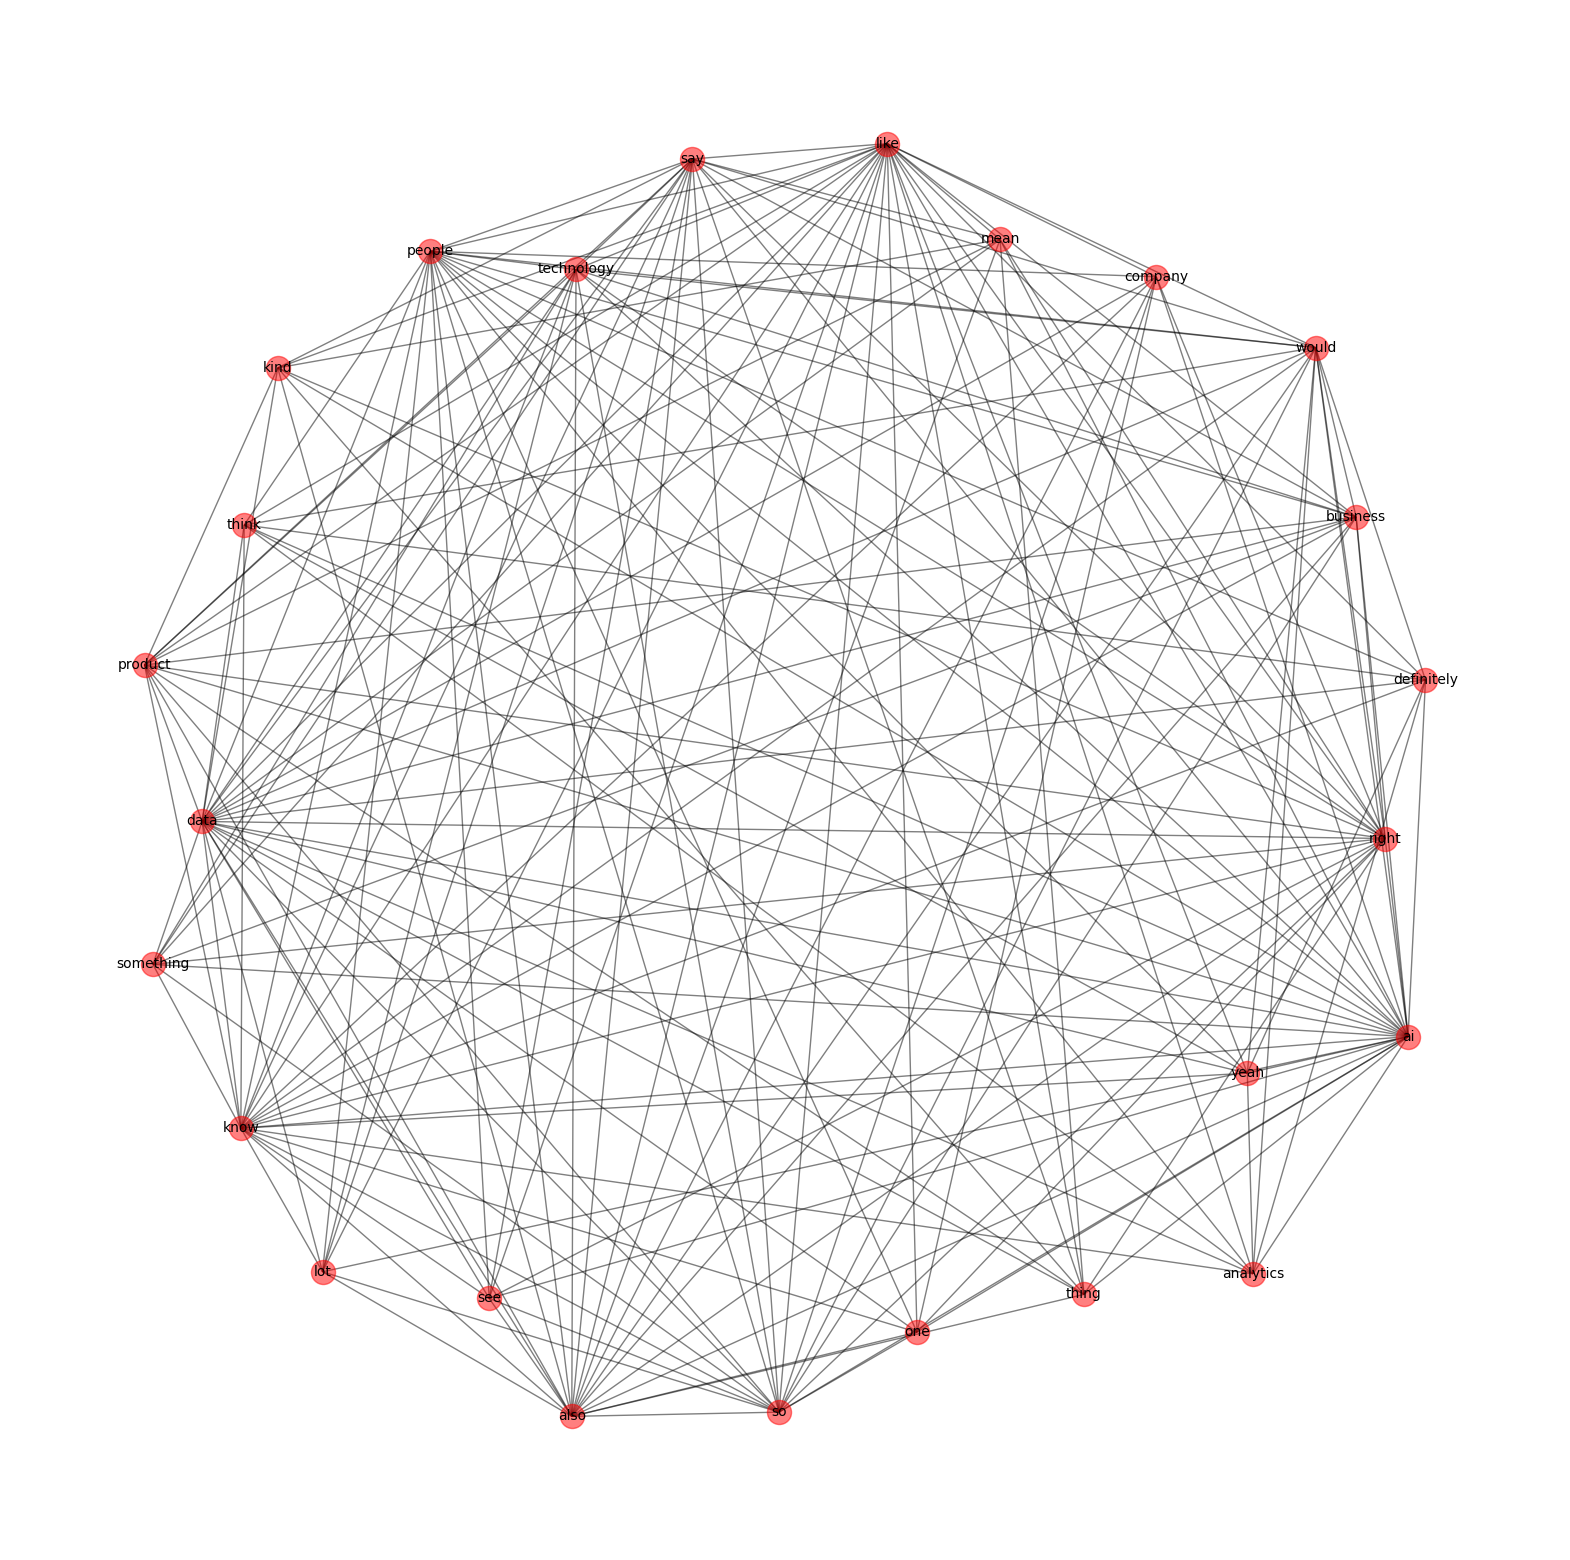

In [29]:
# create a semantic network
G = nx.Graph()

for i, topic in enumerate(topics):
    words = topic[1].split(' + ')
    for word in words:
        weight = float(word.split('*')[0])
        word = word.split('*')[1].replace('"', '')
        if not G.has_node(word):
            G.add_node(word)
        G.nodes[word]['topic'] = i
        for other_word in words:
            other_weight = float(other_word.split('*')[0])
            other_word = other_word.split('*')[1].replace('"', '')
            if word != other_word:
                if not G.has_node(other_word):
                    G.add_node(other_word)
                G.nodes[other_word]['topic'] = i
                if not G.has_edge(word, other_word):
                    G.add_edge(word, other_word, weight=weight*other_weight)

# visualize the semantic network
fig = plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='r', alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()

# save the figure to a file
fig.savefig('./semantic_network.pdf', format='pdf')
